# Setting Environement

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_ROOT = '/content/drive/MyDrive/powerplant_multimodal_project'
os.chdir(PROJECT_ROOT)

Mounted at /content/drive


In [2]:
# import libraries
import pandas as pd
import numpy as np

# tabular_baseline

In [3]:
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'powerplant_data.csv')
df = pd.read_csv(metadata_path)

df = df.drop(0)
df = df.reset_index(drop=True)

# Preview
print(df.shape)
df.head()

(4454, 121)


eGRID2014 Plant file sequence number   Imagery Included   \
0                                    142                YES   
1                                    143                YES   
2                                    144                YES   
3                                    145                YES   
4                                    151                YES   

   Plant state abbreviation          Plant name   \
0                         AL            ABC Coke   
1                         AL   Alabama Pine Pulp   
2                         AL  Alabama River Pulp   
3                         AL         Albertville   
4                         AL               Barry   

  DOE/EIA ORIS plant or facility code        Plant operator name   \
0                               56076            Alabama Power Co   
1                               54429            Alabama Power Co   
2                               10216            Alabama Power Co   
3                                7924  Tennessee Valley Authority   
4                                   3            Alabama Power Co   

  Plant operator ID        Utility service territory name   \
0               195                 Drummond Company, Inc.   
1               195            Alabama River Cellulose LLC   
2               195            Alabama River Cellulose LLC   
3             18642  Albertville Municipal Utilities Board   
4               195                       Alabama Power Co   

  Utility service territory ID                 Balancing Authority Name  ...  \
0                         5321  Southern Company Services, Inc. - Trans  ...   
1                        57356  Southern Company Services, Inc. - Trans  ...   
2                        57356  Southern Company Services, Inc. - Trans  ...   
3                          241               Tennessee Valley Authority  ...   
4                          195  Southern Company Services, Inc. - Trans  ...   

   Plant wind generation percent (resource mix)   \
0                                           -      
1                                           -      
2                                           -      
3                                            NaN   
4                                           -      

   Plant solar generation percent (resource mix)   \
0                                            -      
1                                            -      
2                                            -      
3                                             NaN   
4                                            -      

   Plant geothermal generation percent (resource mix)   \
0                                               -        
1                                               -        
2                                               -        
3                                                NaN     
4                                               -        

   Plant other fossil generation percent (resource mix)   \
0                                              95.9        
1                                               -          
2                                               -          
3                                                NaN       
4                                               -          

   Plant other unknown / purchased fuel generation percent (resource mix)   \
0                                               -                            
1                                               -                            
2                                               -                            
3                                                NaN                         
4                                               -                            

   Plant total nonrenewables generation percent (resource mix)   \
0                                             100.0               
1                                               4.7               
2                             

In [4]:
df.columns = df.columns.str.strip()

selected_plants = ['BIT', 'WAT', 'SUN', 'WND', 'NG']
df = df[df['Plant primary fuel'].isin(selected_plants)]

df['Plant primary fuel'].unique()
fuel_counts = df['Plant primary fuel'].value_counts()
fuel_counts

Plant primary fuel
NG     1160
SUN     850
WAT     688
WND     457
BIT     194
Name: count, dtype: int64

NameError: name 'plt' is not defined

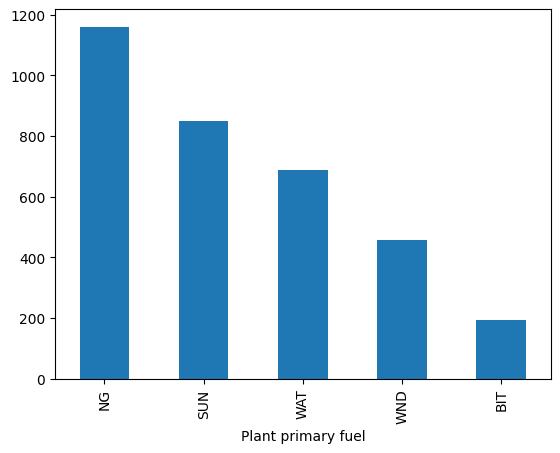

In [5]:
fuel_counts.plot(kind='bar')
plt.title('Distribution of Plant Primary Fuel Types')
plt.xlabel('Plant Primary Fuel')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [6]:
df_missing = df.isna().sum()
df_missing = df_missing.sort_values(ascending=False).head(121)
df_missing.to_dict()

{'Plant unadjusted annual Hg emissions source': 3349,
 'Plant pumped storage flag:                 1 = Yes': 3320,
 'Biogas/ biomass plant adjustment flag': 3308,
 'Flag indicating if the plant  burned or generated any amount of coal:  1 = Yes': 3155,
 'CHP plant power to heat ratio': 3039,
 'CHP plant electric allocation factor': 2955,
 'CHP plant useful thermal output (MMBtu)': 2954,
 'Combined heat and power (CHP) plant adjustment flag:  1 = Yes': 2948,
 'Number of generators': 2936,
 'Plant ozone season NOx input emission rate (lb/MMBtu)': 2196,
 'Plant unadjusted ozone season NOx emissions source': 2192,
 'Plant ozone season NOx combustion output emission rate (lb/MWh)': 2189,
 'Plant annual SO2 combustion output emission rate (lb/MWh)': 2187,
 'Plant annual SO2 input emission rate (lb/MMBtu)': 2186,
 'Plant annual NOx combustion output emission rate (lb/MWh)': 2177,
 'Plant annual CO2 combustion output emission rate (lb/MWh)': 2177,
 'Plant annual CO2 input emission rate (lb/MMBt

In [7]:
numeric_cols = df.select_dtypes(include=['number'])
print(numeric_cols.columns)

Index([], dtype='object')


# preprocessing

In [ ]:
selected_features = [
    "Plant name",
    "Plant state abbreviation",
    "Plant county name",
    "Plant nameplate capacity (MW)",
    "Plant annual net generation (MWh)",
    "Plant annual CO2 emissions (tons)",
    "Plant wind generation percent (resource mix)",
    "Plant solar generation percent (resource mix)",
    "Plant biomass generation percent (resource mix)",
    "Plant primary fuel"  # This is your target
]

df_subset = df[selected_features].dropna()

print(f"Subset shape: {df_subset.shape}")
print("Any missing?", df_subset.isnull().sum())


Subset shape: (2836, 10)
Any missing? Plant name                                         0
Plant state abbreviation                           0
Plant county name                                  0
Plant nameplate capacity (MW)                      0
Plant annual net generation (MWh)                  0
Plant annual CO2 emissions (tons)                  0
Plant wind generation percent (resource mix)       0
Plant solar generation percent (resource mix)      0
Plant biomass generation percent (resource mix)    0
Plant primary fuel                                 0
dtype: int64


In [ ]:
df_subset['Plant primary fuel'].value_counts()

Plant primary fuel
NG     967
SUN    652
WAT    628
WND    415
BIT    174
Name: count, dtype: int64

In [ ]:
# ML libraries
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [ ]:
numeric_cols = ["Plant nameplate capacity (MW)",
    "Plant annual net generation (MWh)",
    "Plant annual CO2 emissions (tons)",
    "Plant wind generation percent (resource mix)",
    "Plant solar generation percent (resource mix)",
    "Plant biomass generation percent (resource mix)"]

categorical_cols = [
    "Plant state abbreviation",
    "Plant county name",]

label_col = ["Plant primary fuel"]

def clean_numeric_column(col):
    return (
        df_subset[col]
        .astype(str)
        .str.replace(r'[^\d\.-]', '', regex=True)
        .str.replace('^-', 'NaN', regex=True)  # Replace '-' with 'NaN' (string)
        .str.replace('^$', 'NaN', regex=True)   # Replace empty strings with 'NaN' (string)
        .astype(float)
    )

# Apply to all numeric columns
for col in numeric_cols:
    df_subset[col] = clean_numeric_column(col)

X = df_subset[categorical_cols + numeric_cols]
y = df_subset[label_col]

In [ ]:
# Preprocessing with Imputer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),  # Or "median", "most_frequent", "constant"
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
}

In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f"\n Evaluating {name} with 5-Fold Stratified CV...")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Run CV scores
    cv_scores = cross_validate(
        pipeline, X, y, cv=cv,
        scoring=["accuracy", "f1_macro"],
        return_train_score=False
    )

    # Predict all labels across folds for detailed metrics
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)

    # Report
    print(f"Accuracy: {np.mean(cv_scores['test_accuracy']):.4f}")
    print(f"Macro F1: {np.mean(cv_scores['test_f1_macro']):.4f}")
    print(classification_report(y, y_pred, digits=3))

    results[name] = {
        "model": model,
        "cv_scores": cv_scores,
        "y_pred": y_pred,
        "report": classification_report(y, y_pred, output_dict=True)
    }


 Evaluating RandomForest with 5-Fold Stratified CV...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Accuracy: 0.9577
Macro F1: 0.9026
              precision    recall  f1-score   support

         BIT      0.916     0.437     0.591       174
          NG      0.900     0.991     0.943       967
         SUN      1.000     0.998     0.999       652
         WAT      0.989     0.986     0.987       628
         WND      1.000     0.993     0.996       415

    accuracy                          0.958      2836
   macro avg      0.961     0.881     0.904      2836
weighted avg      0.958     0.958     0.952      2836


 Evaluating LogisticRegression with 5-Fold Stratified CV...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Accuracy: 0.9150
Macro F1: 0.8669
              precision    recall  f1-score   support

         BIT      0.810     0.489     0.609       174
          NG      0.900     0.973     0.935       967
         SUN      0.942     0.971     0.956       652
         WAT      0.902     0.861     0.881       628
         WND      0.954     0.952     0.953       415

    accuracy                          0.915      2836
   macro avg      0.902     0.849     0.867      2836
weighted avg      0.913     0.915     0.911      2836


 Evaluating MLP with 5-Fold Stratified CV...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Accuracy: 0.9133
Macro F1: 0.8721
              precision    recall  f1-score   support

         BIT      0.686     0.615     0.648       174
          NG      0.919     0.940     0.929       967
         SUN      0.967     0.975     0.971       652
         WAT      0.905     0.882     0.894       628
         WND      0.912     0.925     0.919       415

    accuracy                          0.913      2836
   macro avg      0.878     0.868     0.872      2836
weighted avg      0.912     0.913     0.912      2836



In [ ]:
# Saving Models
import joblib
import os

model_path = os.path.join(PROJECT_ROOT, 'src', 'models')
os.makedirs(model_path, exist_ok=True)

for name, model in models.items():
    print(f"\n Re-training {name} on full data and saving...")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    pipeline.fit(X, y)  # Train on ALL of df_subset

    filename = os.path.join(model_path, f"{name}_pipeline.joblib")
    joblib.dump(pipeline, filename)
    print(f" Saved: {filename}")



🔁 Re-training RandomForest on full data and saving...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved: /content/drive/MyDrive/powerplant_multimodal_project/src/models/RandomForest_pipeline.joblib

🔁 Re-training LogisticRegression on full data and saving...
✅ Saved: /content/drive/MyDrive/powerplant_multimodal_project/src/models/LogisticRegression_pipeline.joblib

🔁 Re-training MLP on full data and saving...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ Saved: /content/drive/MyDrive/powerplant_multimodal_project/src/models/MLP_pipeline.joblib


# PHASE 2, Baselining Retrieval

In [ ]:
pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
from groq import Groq
import pandas as pd
from tqdm import tqdm
import json
import os

In [ ]:
client = Groq(api_key="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")

In [ ]:
FUEL_TYPE_MAP = {
    "BIT": "bituminous coal",
    "NG": "natural gas",
    "WAT": "hydropower",
    "SUN": "solar energy",
    "WND": "wind energy",
    "BIO": "biomass",
    "NUC": "nuclear power",
    "SUB": "subbituminous coal",
    "LIG": "lignite",
    "RC": "refined coal",
    "WH": "waste heat",
    "AB": "agricultural byproducts",
    "MSW": "municipal solid waste",
    "OTH": "other",
}

def build_prompt(row):
    # Expand fuel type
    fuel_abbr = row['Plant primary fuel']
    fuel_full = FUEL_TYPE_MAP.get(fuel_abbr, fuel_abbr.lower())

    return f"""
You are an energy data assistant. Given structured metadata about a U.S. power plant, generate a single formal, factual English paragraph that describes the plant. Use all available fields. Do not explain your reasoning. Do not include any bullet points, markdown, or tags. Do not use personal pronouns.

⚠️ Style guidelines:
- Write "carbon dioxide" instead of "CO₂"
- Write out fuel type in full (e.g., "bituminous coal" instead of "BIT")
- Assume electricity generation and emissions are measured **per year**, unless otherwise stated

Metadata:
Plant name: {row['Plant name']}
State: {row['Plant state abbreviation']}
County: {row['Plant county name']}
Fuel type: {fuel_full}
Capacity: {row['Plant nameplate capacity (MW)']} MW
Net generation: {row['Plant annual net generation (MWh)']} MWh
CO₂ emissions: {row['Plant annual CO2 emissions (tons)']} tons
Wind mix: {row['Plant wind generation percent (resource mix)']}%
Solar mix: {row['Plant solar generation percent (resource mix)']}%
Biomass mix: {row['Plant biomass generation percent (resource mix)']}%

Write only the final paragraph below:
"""



In [ ]:
df_retrieval = df_subset

In [ ]:
df_retrieval.columns

Index(['Plant name', 'Plant state abbreviation', 'Plant county name',
       'Plant nameplate capacity (MW)', 'Plant annual net generation (MWh)',
       'Plant annual CO2 emissions (tons)',
       'Plant wind generation percent (resource mix)',
       'Plant solar generation percent (resource mix)',
       'Plant biomass generation percent (resource mix)',
       'Plant primary fuel'],
      dtype='object')

In [ ]:
selected_cols = [
    "Plant name", "Plant state abbreviation", "Plant county name",
    "Plant nameplate capacity (MW)", "Plant annual net generation (MWh)",
    "Plant annual CO2 emissions (tons)", "Plant wind generation percent (resource mix)",
    "Plant solar generation percent (resource mix)", "Plant biomass generation percent (resource mix)",
    "Plant primary fuel"

]

df_json_ready = df_retrieval[selected_cols].copy()

# Clean columns: remove units, format NaNs
df_json_ready = df_json_ready.replace(["-", "nan", "NaN", ""], np.nan)
df_json_ready = df_json_ready.dropna(subset=["Plant name"])  # Must have plant name

# Convert to list of dicts
json_plants = df_json_ready.fillna("unknown").to_dict(orient="records")

In [ ]:
json_plants[0]

{'Plant name': 'Barry',
 'Plant state abbreviation': 'AL',
 'Plant county name': 'Mobile',
 'Plant nameplate capacity (MW)': 2841.5,
 'Plant annual net generation (MWh)': 12981029.0,
 'Plant annual CO2 emissions (tons)': 9044111.0,
 'Plant wind generation percent (resource mix)': 'unknown',
 'Plant solar generation percent (resource mix)': 'unknown',
 'Plant biomass generation percent (resource mix)': 'unknown',
 'Plant primary fuel': 'BIT'}

In [ ]:
samples = json_plants[:10]
df_sample = df_json_ready.iloc[:10].copy()

In [ ]:
models = client.models.list()
for m in models.data:
    print(m.id)

llama-3.3-70b-versatile
mistral-saba-24b
whisper-large-v3
qwen-qwq-32b
compound-beta
playai-tts
meta-llama/llama-4-scout-17b-16e-instruct
distil-whisper-large-v3-en
meta-llama/llama-4-maverick-17b-128e-instruct
whisper-large-v3-turbo
llama3-70b-8192
gemma2-9b-it
playai-tts-arabic
llama-guard-3-8b
llama-3.1-8b-instant
compound-beta-mini
deepseek-r1-distill-llama-70b
allam-2-7b
llama3-8b-8192


In [21]:
captions = []

for i, plant in tqdm(enumerate(json_plants), total=len(json_plants)):
    try:
        prompt = build_prompt(plant)
        response = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.6,
            top_p=0.95,
            max_tokens=256
        )
        output = response.choices[0].message.content if response.choices else "CAPTION_GENERATION_FAILED"
        captions.append(output)
    except Exception as e:
        print(f"⚠️ Error generating caption for row {i}: {e}")
        captions.append("CAPTION_GENERATION_FAILED")

df_json_ready["caption"] = captions
# df_sample["caption"] = captions

NameError: name 'json_plants' is not defined

In [ ]:
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata_with_captions.csv')
df_json_ready.to_csv(metadata_path, index=False)
print(f"✅ Captions saved to: {metadata_path}")

✅ Captions saved to: /content/drive/MyDrive/powerplant_multimodal_project/data/processed/metadata_with_captions.csv


In [ ]:
pd.set_option('display.max_colwidth', None)
print(df_json_ready['caption'].head(10))


# reset column width
# pd.reset_option('display.max_colwidth')

4                                                                                                                                                                                                                The Barry power plant, located in Mobile County, Alabama, is a bituminous coal-fired facility with a capacity of 2841.5 megawatts. Annually, it generates 12981029.0 megawatt-hours of electricity and emits 9044111.0 tons of carbon dioxide.
6                                                                                                                                                                                                        The Calhoun Energy Center is a natural gas-fired power plant located in Calhoun County, Alabama, with an installed capacity of 748.0 MW. In a typical year, the plant generates 28,639.0 MWh of electricity and emits 23,145.0 tons of carbon dioxide.
7                                                                                                       

In [ ]:
df_json_ready

Plant name Plant state abbreviation  \
4                                 Barry                       AL   
6                 Calhoun Energy Center                       AL   
7                      Charles R Lowman                       AL   
8                               Colbert                       AL   
9                 Decatur Energy Center                       AL   
...                                 ...                      ...   
4446                       Wind Turbine                       WI   
4448                   Wisconsin Rapids                       WI   
4450                            Wissota                       WI   
4452   Axiall Corporation Natrium Plant                       WV   
4453  Bayer CropScience Institute Plant                       WV   

     Plant county name  Plant nameplate capacity (MW)  \
4               Mobile                         2841.5   
6              Calhoun                          748.0   
7           Washington                          538.0   
8              Colbert                         1826.0   
9               Morgan                          902.4   
...                ...                            ...   
4446          Kewaunee                           11.0   
4448              Wood                            8.8   
4450          Chippewa                           39.4   
4452          Marshall                          123.0   
4453           Kanawha                           12.6   

      Plant annual net generation (MWh)  Plant annual CO2 emissions (tons)  \
4                            12981029.0                          9044111.0   
6                               28639.0                            23145.0   
7                             1876861.0                          2366851.0   
8                             3594781.0                          5542308.0   
9                              991669.0                           450375.0   
...                                 ...                                ...   
4446                            17717.0                                NaN   
4448                            53798.0                                NaN   
4450                           177343.0                                NaN   
4452                           586275.0                           351911.0   
4453                            18260.0                           216695.0   

      Plant wind generation percent (resource mix)  \
4                                              NaN   
6                                              NaN   
7                                              NaN   
8                                              NaN   
9                                              NaN   
...                                            ...   
4446                                         100.0   
4448                                           NaN   
4450                                           NaN   
4452                                           NaN   
4453                                           NaN   

      Plant solar generation percent (resource mix)  \
4                                               NaN   
6                                               NaN   
7                                               NaN   
8                                               NaN   
9                                               NaN   
...                                             ...   
4446                                            NaN   
4448                                            NaN   
4450                                            NaN   
4452                                            NaN   
4453                                            NaN   

      Plant biomass generation percent (resource mix) Plant primary fuel  \
4                                                 NaN                BIT   
6                                                 NaN                 NG   
7                                                 Na

# Phase 2: TF-IDF Text Retrieval (Metadata as Caption)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_ROOT = '/content/drive/MyDrive/powerplant_multimodal_project'
os.chdir(PROJECT_ROOT)


Mounted at /content/drive


In [ ]:
# load processed metadata with caption
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata_with_captions.csv')
df = pd.read_csv(metadata_path)

In [ ]:
captions = df["caption"].fillna("").tolist()
captions

['The Barry power plant, located in Mobile County, Alabama, is a bituminous coal-fired facility with a capacity of 2841.5 megawatts. Annually, it generates 12981029.0 megawatt-hours of electricity and emits 9044111.0 tons of carbon dioxide.',
 'The Calhoun Energy Center is a natural gas-fired power plant located in Calhoun County, Alabama, with an installed capacity of 748.0 MW. In a typical year, the plant generates 28,639.0 MWh of electricity and emits 23,145.0 tons of carbon dioxide.',
 'The Charles R Lowman power plant, located in Washington County, Alabama, has an installed capacity of 538.0 megawatts and generates 1876861.0 megawatt-hours of electricity per year. The plant burns bituminous coal as its primary fuel source and emits 2366851.0 tons of carbon dioxide per year.',
 'The Colbert power plant, located in Colbert County, Alabama, is a bituminous coal-fired facility with an installed capacity of 1826.0 megawatts. Annually, the plant generates 3594781.0 megawatt-hours of ele

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(captions)

# Cosine Similarity
similarity_matrix = cosine_similarity(tfidf_matrix)


In [ ]:
similarity_matrix

array([[1.        , 0.12336251, 0.19123947, ..., 0.03451519, 0.13698081,
        0.13017251],
       [0.12336251, 1.        , 0.12146303, ..., 0.02441523, 0.06010654,
        0.05711909],
       [0.19123947, 0.12146303, 1.        , ..., 0.04063196, 0.11592892,
        0.11016696],
       ...,
       [0.03451519, 0.02441523, 0.04063196, ..., 1.        , 0.03035917,
        0.02885024],
       [0.13698081, 0.06010654, 0.11592892, ..., 0.03035917, 1.        ,
        0.22271412],
       [0.13017251, 0.05711909, 0.11016696, ..., 0.02885024, 0.22271412,
        1.        ]])

In [ ]:
# Top-5 similar captions (excluding self)
top_k = 5
top_k_indices = np.argsort(-similarity_matrix, axis=1)[:, 1:top_k+1]
top_k_results = []

for i, indices in enumerate(top_k_indices):
    plant_name = df.iloc[i]["Plant name"]
    matches = df.iloc[indices]["Plant name"].tolist()
    top_k_results.append({
        "query_plant": plant_name,
        "top_5_matches": matches
    })

In [ ]:
for result in top_k_results:
    print(f"Query Plant: {result['query_plant']}")
    print(f"Top 5 Matches: {result['top_5_matches']}")
    print("-" * 30)

Query Plant: Barry
Top 5 Matches: ['ExxonMobil Mobile Bay Onshore', 'Mobile Energy Services LLC', 'Theodore Cogeneration', 'Shell Offshore Yellowhammer', 'Colbert']
------------------------------
Query Plant: Calhoun Energy Center
Top 5 Matches: ['CFB Power Plant', 'The Andersons Albion Ethanol LLC', 'Columbia Energy Center (SC)', 'Battle Creek Mill', 'H Neely Henry Dam']
------------------------------
Query Plant: Charles R Lowman
Top 5 Matches: ['E C Gaston', 'Indiantown Cogeneration, LP', 'Morgantown', 'Washington City Electric Generation', 'Muskingum River']
------------------------------
Query Plant: Colbert
Top 5 Matches: ['Barry', 'E C Gaston', 'Charles R Lowman', 'Greene County', 'Tenaska Central Alabama Gen Station']
------------------------------
Query Plant: Decatur Energy Center
Top 5 Matches: ['Morgan Energy Center', 'Yuba City Energy Center', 'New-Indy Ontario Mill', 'Blackhawk Station', 'Tilton Power Station']
------------------------------
Query Plant: E C Gaston
Top 5 

In [ ]:
# Eval
true_labels = df["Plant primary fuel"].tolist()  # e.g., "BIT", "NG", "WAT", etc.
def recall_at_k(true_labels, top_k_indices, k):
    recalls = []
    for i, indices in enumerate(top_k_indices[:, :k]):
        query_label = true_labels[i]
        retrieved_labels = [true_labels[j] for j in indices]
        hit = query_label in retrieved_labels
        recalls.append(1 if hit else 0)
    return np.mean(recalls)


In [ ]:
def mean_average_precision(true_labels, top_k_indices, k):
    average_precisions = []
    for i, indices in enumerate(top_k_indices[:, :k]):
        query_label = true_labels[i]
        correct = 0
        total_precision = 0
        for rank, idx in enumerate(indices):
            if true_labels[idx] == query_label:
                correct += 1
                total_precision += correct / (rank + 1)
        if correct > 0:
            average_precisions.append(total_precision / correct)
        else:
            average_precisions.append(0)
    return np.mean(average_precisions)


In [ ]:
recall1 = recall_at_k(true_labels, top_k_indices, k=1)
recall5 = recall_at_k(true_labels, top_k_indices, k=5)
map5 = mean_average_precision(true_labels, top_k_indices, k=5)

print(f"📌 Recall@1: {recall1:.3f}")
print(f"📌 Recall@5: {recall5:.3f}")
print(f"📌 mAP@5: {map5:.3f}")


📌 Recall@1: 0.857
📌 Recall@5: 0.991
📌 mAP@5: 0.896


# FAISS

In [ ]:
!pip install sentence-transformers faiss-cpu

from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
df['caption'].head()

0    The Barry power plant, located in Mobile Count...
1    The Calhoun Energy Center is a natural gas-fir...
2    The Charles R Lowman power plant, located in W...
3    The Colbert power plant, located in Colbert Co...
4    The Decatur Energy Center, located in Morgan C...
Name: caption, dtype: object

In [ ]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

captions = df["caption"].fillna("").tolist()
embeddings = model.encode(captions, convert_to_numpy=True, normalize_embeddings=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)

top_k = 5
_, top_k_indices = index.search(embeddings, top_k + 1)
top_k_indices = top_k_indices[:, 1:]  # exclude self

labels = df["Plant primary fuel"].tolist()

def recall_at_k(true, preds, k):
    return np.mean([1 if true[i] in [true[j] for j in preds[i][:k]] else 0 for i in range(len(true))])

def mean_avg_precision(true, preds, k):
    mAP = []
    for i in range(len(true)):
        label = true[i]
        correct, precision_sum = 0, 0
        for rank, idx in enumerate(preds[i][:k]):
            if true[idx] == label:
                correct += 1
                precision_sum += correct / (rank + 1)
        mAP.append(precision_sum / correct if correct else 0)
    return np.mean(mAP)

In [ ]:
# Evaluate
print(f"📌 Recall@1: {recall_at_k(labels, top_k_indices, 1):.3f}")
print(f"📌 Recall@5: {recall_at_k(labels, top_k_indices, 5):.3f}")
print(f"📌 mAP@5: {mean_avg_precision(labels, top_k_indices, 5):.3f}")

📌 Recall@1: 0.730
📌 Recall@5: 0.956
📌 mAP@5: 0.798


# Phase 2 - Benchmarking CLIP
How good is clip in classifying images to their respective classes

In [8]:
pip install transformers torchvision pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [9]:
import os
import pandas as pd
import torch
from PIL import Image
from collections import defaultdict
import random
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [10]:
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
NAIP_DIR = os.path.join(PROJECT_ROOT, 'data', 'raw', 'uspp_naip', 'uspp_naip')

In [ ]:
FUEL_MAP = {
    "BIT": "a photo of a coal power plant",
    "NG": "a photo of a natural gas power plant",
    "SUN": "a photo of a solar power plant",
    "WAT": "a photo of a hydroelectric power plant",
    "WND": "a photo of a wind power plant"
}

In [ ]:
# Load CLIP model & processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

from collections import defaultdict
import random

# Step 1: Build a label → image_path map
label_to_paths = defaultdict(list)
for fname in os.listdir(NAIP_DIR):
    if fname.endswith(".tif"):
        fuel = fname.split("_")[-1].replace(".tif", "")
        if fuel in FUEL_MAP:
            label_to_paths[fuel].append(os.path.join(NAIP_DIR, fname))

# Step 2: Balance to n=100 per class
sample_n = 100
image_paths, labels = [], []
for fuel, paths in label_to_paths.items():
    selected = random.sample(paths, min(sample_n, len(paths)))
    image_paths.extend(selected)
    labels.extend([fuel] * len(selected))

print(f"🖼️ Loaded {len(image_paths)} total images (balanced across fuel types)")


🖼️ Loaded 500 total images (balanced across fuel types)


In [ ]:
# Encode prompt texts
prompt_texts = list(FUEL_MAP.values())
prompt_inputs = clip_processor(text=prompt_texts, return_tensors="pt", padding=True)
with torch.no_grad():
    text_features = clip_model.get_text_features(**prompt_inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

In [ ]:
# Predict fuel type from image
preds = []
for path in image_paths:
    image = Image.open(path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        sims = torch.matmul(image_features, text_features.T)
        pred_idx = torch.argmax(sims, dim=-1).item()
        pred_class = list(FUEL_MAP.keys())[pred_idx]
        preds.append(pred_class)

In [ ]:
# Evaluate
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="macro")
print("📊 Accuracy:", round(acc, 3))
print("📊 Macro F1:", round(f1, 3))
print("\n", classification_report(labels, preds))
print("\nConfusion Matrix:\n", confusion_matrix(labels, preds))

📊 Accuracy: 0.522
📊 Macro F1: 0.484

               precision    recall  f1-score   support

         BIT       0.80      0.04      0.08       100
          NG       0.33      0.88      0.48       100
         SUN       0.69      0.51      0.59       100
         WAT       0.73      0.83      0.78       100
         WND       0.92      0.35      0.51       100

    accuracy                           0.52       500
   macro avg       0.69      0.52      0.48       500
weighted avg       0.69      0.52      0.48       500


Confusion Matrix:
 [[ 4 84  0 11  1]
 [ 0 88  4  8  0]
 [ 0 44 51  4  1]
 [ 1 14  1 83  1]
 [ 0 39 18  8 35]]


### Testing CLIP and SBERT (image-text retrival)
1. Import Pretrained CLIP
2. Get corresponding Image-Text Embeddings
3. Cosine Similarity Matrix
4. I2T and T2I Evaluation
5. Top-1 & Top-5 Accuracy - Standard Metrics

In [ ]:
pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.4.1
    Uninstalling sentence-transformers-3.4.1:
      Successfully uninstalled sentence-transformers-3.4.1


In [ ]:
import os
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel

In [ ]:
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata_with_captions.csv')
df = pd.read_csv(metadata_path)

data_path = os.path.join(PROJECT_ROOT, "data", "raw", "powerplant_data.csv")
df_raw= pd.read_csv(data_path)

In [ ]:
df.columns = df.columns.str.strip()
df_raw.columns = df_raw.columns.str.strip()

df = pd.merge(
    df,
    df_raw[["Plant name", "eGRID2014 Plant file sequence number"]],
    on="Plant name",
    how="left"
)

df.rename(columns={"eGRID2014 Plant file sequence number": "sequence_number"}, inplace=True)

In [ ]:
NAIP_DIR = os.path.join(PROJECT_ROOT, "data", "raw", "uspp_naip", "uspp_naip")

# Build a label → image_path map
label_to_paths = defaultdict(list)
for fname in os.listdir(NAIP_DIR):
    if fname.endswith(".tif"):
        fuel = fname.split("_")[-1].replace(".tif", "")
        if fuel in FUEL_MAP:
            label_to_paths[fuel].append(os.path.join(NAIP_DIR, fname))

# balance to n=100 per class
sample_n = 100
image_paths, labels = [], []
for fuel, paths in label_to_paths.items():
    selected = random.sample(paths, min(sample_n, len(paths)))
    image_paths.extend(selected)
    labels.extend([fuel] * len(selected))

print(f"Loaded {len(image_paths)} total images (balanced across fuel types)")
print(f"Total image paths: {len(image_paths)}")
print(f"Example path: {image_paths[0] if image_paths else 'EMPTY'}")


Loaded 500 total images (balanced across fuel types)
Total image paths: 500
Example path: /content/drive/MyDrive/powerplant_multimodal_project/data/raw/uspp_naip/uspp_naip/naip_3730_MA_WAT.tif


In [ ]:
image_paths = []
labels = []

sample_n = 100
for fuel, paths in label_to_paths.items():
    selected = random.sample(paths, min(sample_n, len(paths)))
    image_paths.extend(selected)
    labels.extend([fuel] * len(selected))

print(f"\nLoaded total: {len(image_paths)} images across fuel types")
print("Class distribution BEFORE filter:", Counter(labels))
print("Example image:", image_paths[0])

df['sequence_number'] = df['sequence_number'].astype(int)
caption_map = dict(zip(df['sequence_number'], df['caption']))

def extract_seq(filename):
    try:
        return int(filename.split("_")[1])
    except:
        return None


valid_image_paths, valid_captions, valid_labels = [], [], []

for path, label in zip(image_paths, labels):
    seq_id = extract_seq(os.path.basename(path))
    if seq_id in caption_map:
        valid_image_paths.append(path)
        valid_captions.append(caption_map[seq_id])
        valid_labels.append(label)

print(f"\nTotal valid image-caption pairs AFTER filtering: {len(valid_image_paths)}")
print("Class distribution AFTER filter:", Counter(valid_labels))
print("Example caption:", valid_captions[0])



Loaded total: 500 images across fuel types
Class distribution BEFORE filter: Counter({'WAT': 100, 'WND': 100, 'NG': 100, 'SUN': 100, 'BIT': 100})
Example image: /content/drive/MyDrive/powerplant_multimodal_project/data/raw/uspp_naip/uspp_naip/naip_4555_MO_WAT.tif

Total valid image-caption pairs AFTER filtering: 446
Class distribution AFTER filter: Counter({'WND': 95, 'BIT': 93, 'WAT': 90, 'NG': 84, 'SUN': 84})
Example caption: The Clarence Cannon power plant, located in Ralls County, Missouri, is a hydropower facility with an installed capacity of 58.0 megawatts. Annually, the plant generates 84,772 megawatt-hours of electricity.


In [ ]:
# Load CLIP model & processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Encode captions with CLIP text encoder
inputs = clip_processor(
    text=filtered_captions,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=77
)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    caption_emb = clip_model.get_text_features(**inputs)
caption_emb = caption_emb / caption_emb.norm(dim=1, keepdim=True)
caption_emb_np = caption_emb.cpu().numpy()

# Encode images with CLIP image encoder
image_emb = []
for path in tqdm(filtered_image_paths, desc="Encoding images"):
    img = Image.open(path).convert("RGB")
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        feat = clip_model.get_image_features(**inputs)
    feat = feat / feat.norm(dim=1, keepdim=True)
    image_emb.append(feat.squeeze().cpu().numpy())

image_emb_np = np.stack(image_emb)

Encoding images: 100%|██████████| 332/332 [00:43<00:00,  7.63it/s]


In [ ]:
sim_matrix = cosine_similarity(image_emb_np, caption_emb_np)

In [ ]:
top1_preds = np.argmax(sim_matrix, axis=1)
correct = np.arange(len(top1_preds))
top1_acc = np.mean(top1_preds == correct)

top5_preds = np.argsort(sim_matrix, axis=1)[:, -5:]
top5_acc = np.mean([i in top5 for i, top5 in enumerate(top5_preds)])

print(f"CLIP I2T Top-1 Accuracy: {top1_acc:.4f}")
print(f"CLIP I2T Top-5 Accuracy: {top5_acc:.4f}")


CLIP I2T Top-1 Accuracy: 0.0512
CLIP I2T Top-5 Accuracy: 0.1928


In [ ]:
sim_matrix_T = sim_matrix.T

top1_preds_T = np.argmax(sim_matrix_T, axis=1)
correct_T = np.arange(len(top1_preds_T))
top1_acc_T = np.mean(top1_preds_T == correct_T)

top5_preds_T = np.argsort(sim_matrix_T, axis=1)[:, -5:]
top5_acc_T = np.mean([i in top5 for i, top5 in enumerate(top5_preds_T)])

print(f"CLIP T2I Top-1 Accuracy: {top1_acc_T:.4f}")
print(f"CLIP T2I Top-5 Accuracy: {top5_acc_T:.4f}")

CLIP T2I Top-1 Accuracy: 0.0482
CLIP T2I Top-5 Accuracy: 0.1566


| Metric                     | Value  | Interpretation                                                                                                |
| :------------------------- | :----- | :---------------------------------------------------------------------------------------------------------- |
| Image-to-Text Top-1 (I2T) | 0.0512 | Only ~5.1% of the time does the correct caption rank #1 when retrieving from image embeddings.               |
| Image-to-Text Top-5 (I2T) | 0.1928 | About ~19.3% of the time, the correct caption is in the top-5 most similar captions for a given image.       |
| Text-to-Image Top-1 (T2I) | 0.0482 | For ~4.8% of captions, the correct image is retrieved as #1.                                                |
| Text-to-Image Top-5 (T2I) | 0.1566 | The correct image appears in the top-5 results for ~15.7% of captions.                                     |

# PIPELINE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_ROOT = '/content/drive/MyDrive/powerplant_multimodal_project'
os.chdir(PROJECT_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 68.1 MB/s eta 0:00:00


In [34]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from transformers import ViTModel, ViTConfig
import os
from torchvision import transforms
from transformers import AutoTokenizer
from transformers import RobertaTokenizer
from collections import defaultdict, Counter
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import ViTModel, RobertaModel
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata_with_captions.csv')
df = pd.read_csv(metadata_path)

data_path = os.path.join(PROJECT_ROOT, "data", "raw", "powerplant_data.csv")
df_raw= pd.read_csv(data_path)

df.columns = df.columns.str.strip()
df_raw.columns = df_raw.columns.str.strip()

df = pd.merge(
    df,
    df_raw[["Plant name", "eGRID2014 Plant file sequence number"]],
    on="Plant name",
    how="left"
)

df.rename(columns={"eGRID2014 Plant file sequence number": "sequence_number"}, inplace=True)


In [17]:
# 5. Collect all raw images
NAIP_DIR = os.path.join(PROJECT_ROOT, "data", "raw", "uspp_naip", "uspp_naip")
label_to_paths = defaultdict(list)

allowed_fuels = ["BIT", "NG", "SUN", "WND", "WAT"]

for fname in os.listdir(NAIP_DIR):
    if fname.endswith(".tif"):
        fuel = fname.split("_")[-1].replace(".tif", "")
        if fuel in allowed_fuels:
            label_to_paths[fuel].append(os.path.join(NAIP_DIR, fname))

image_paths = []
labels = []
for fuel, paths in label_to_paths.items():
    image_paths.extend(paths)
    labels.extend([fuel] * len(paths))

print(f"Loaded {len(image_paths)} total images across 5 classes")
print("Class distribution:", Counter(labels))


Loaded 2262 total images across 5 classes
Class distribution: Counter({'NG': 765, 'SUN': 707, 'WAT': 376, 'WND': 296, 'BIT': 118})


In [18]:
# 6. Map images to available captions

# Build sequence_number → caption map
caption_map = dict(zip(df["sequence_number"].astype(int), df["caption"]))

# Extract and match
def extract_seq(filename):
    try:
        parts = filename.replace(".tif", "").split("_")
        if len(parts) >= 3:
            return int(parts[1])  # Second part is sequence number
    except:
        pass
    return None

valid_image_paths = []
valid_captions = []
valid_labels = []

for path, label in zip(image_paths, labels):
    filename = os.path.basename(path)
    seq_id = extract_seq(filename)

    if seq_id is not None and seq_id in caption_map:
        valid_image_paths.append(path)
        valid_captions.append(caption_map[seq_id])
        valid_labels.append(label)

print(f"✅ Matched {len(valid_image_paths)} valid (image, caption) pairs.")
print("Class distribution of matched samples:", Counter(valid_labels))


✅ Matched 1912 valid (image, caption) pairs.
Class distribution of matched samples: Counter({'NG': 639, 'SUN': 552, 'WAT': 342, 'WND': 269, 'BIT': 110})


In [19]:
# 7. Split into trainval/test
from sklearn.model_selection import train_test_split

trainval_image_paths, test_image_paths, trainval_labels, test_labels, trainval_captions, test_captions = train_test_split(
    valid_image_paths,
    valid_labels,
    valid_captions,
    test_size=0.15,
    stratify=valid_labels,
    random_state=42
)

print(f"✅ Train+Val samples: {len(trainval_image_paths)}")
print(f"✅ Test samples: {len(test_image_paths)}")


✅ Train+Val samples: 1625
✅ Test samples: 287


In [20]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PowerPlantContrastiveDataset(Dataset):
    def __init__(self, image_paths, captions, labels, image_transform, text_tokenizer):
        self.image_paths = image_paths
        self.captions = captions
        self.labels = labels
        self.image_transform = image_transform
        self.tokenizer = text_tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        caption = self.captions[idx]
        label = self.labels[idx]

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        if self.image_transform:  # <- just to be safe
            image = self.image_transform(image)

        # Tokenize caption
        encoded = self.tokenizer(
            caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77  # (77 is standard if you're following CLIP-style input)
        )
        input_ids = encoded["input_ids"].squeeze(0)       # (remove batch dimension)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "fuel_type": label,
            "caption": caption,
            "filename": os.path.basename(img_path)
        }

import torchvision.transforms as T
from transformers import AutoTokenizer

# Image transform
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Text tokenizer
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [21]:
# Define the Dataset class (You already have this earlier)
# class PowerPlantContrastiveDataset ...

# Create trainval dataset
full_trainval_dataset = PowerPlantContrastiveDataset(
    trainval_image_paths,
    trainval_captions,
    trainval_labels,
    image_transform,
    text_tokenizer
)

# Create test dataset
final_test_dataset = PowerPlantContrastiveDataset(
    test_image_paths,
    test_captions,
    test_labels,
    image_transform,
    text_tokenizer
)

from torch.utils.data import DataLoader

full_trainval_loader = DataLoader(
    full_trainval_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

final_test_loader = DataLoader(
    final_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

In [22]:
print(len(final_test_dataset))

287


Caption: The PSEG Hackettstown power plant, located in Warren County, New Jersey, is a solar energy-fueled facility with an installed capacity of 2.2 megawatts. In a year, it generates 2510.0 megawatt-hours of electricity. The plant's fuel mix consists of 100.0 percent solar energy, with no reported biomass or wind components. Carbon dioxide emissions data for this facility are currently unknown.
Fuel Type: SUN
Filename: naip_5698_NJ_SUN.tif


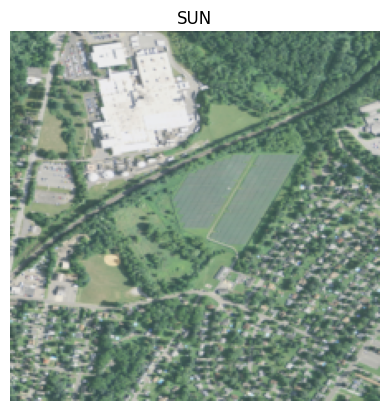

In [23]:
import torch

sample = full_trainval_dataset[10]

print("Caption:", sample["caption"])
print("Fuel Type:", sample["fuel_type"])
print("Filename:", sample["filename"])

# Unnormalize properly
img = sample["image"]

# Unnormalize using the ImageNet mean and std
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

img = img * std + mean  # Unnormalize
img = img.permute(1, 2, 0).clamp(0, 1)  # (C, H, W) -> (H, W, C) and clamp to [0,1]

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title(sample["fuel_type"])
plt.show()


In [24]:
class LitContrastiveModel(pl.LightningModule):
    def __init__(self, image_encoder, text_encoder, temperature=0.07, lr=1e-4):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temperature = temperature
        self.lr = lr
        self.train_epoch_losses = []  # ✅
        self.val_epoch_losses = []    # ✅
        self.running_train_losses = []  # ✅ temporary list to track per step
        self.running_val_losses = []    # ✅ temporary list to track per step

    def forward(self, image, input_ids, attention_mask):
        image_emb = self.image_encoder(image).last_hidden_state[:, 0]
        text_emb = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return image_emb, text_emb

    def compute_loss(self, image_emb, text_emb):
        image_emb = F.normalize(image_emb, dim=1)
        text_emb = F.normalize(text_emb, dim=1)
        logits = torch.matmul(image_emb, text_emb.T) / self.temperature
        labels = torch.arange(len(image_emb), device=self.device)
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        return (loss_i2t + loss_t2i) / 2

    def training_step(self, batch, batch_idx):
        image = batch["image"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        image_emb, text_emb = self(image, input_ids, attention_mask)
        loss = self.compute_loss(image_emb, text_emb)

        self.running_train_losses.append(loss)  # ✅ Collect at each step
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        # ✅ Compute average of the running losses
        avg_loss = torch.stack(self.running_train_losses).mean()
        self.train_epoch_losses.append(avg_loss.item())
        self.running_train_losses.clear()  # ✅ Reset for next epoch

    def validation_step(self, batch, batch_idx):
        image = batch["image"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        image_emb, text_emb = self(image, input_ids, attention_mask)
        loss = self.compute_loss(image_emb, text_emb)

        self.running_val_losses.append(loss)  # ✅ Collect at each step
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        # ✅ Compute average of the running losses
        avg_val_loss = torch.stack(self.running_val_losses).mean()
        self.val_epoch_losses.append(avg_val_loss.item())
        self.running_val_losses.clear()  # ✅ Reset for next epoch

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

    def test_step(self, batch, batch_idx):
        image = batch["image"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        image_emb, text_emb = self(image, input_ids, attention_mask)
        loss = self.compute_loss(image_emb, text_emb)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from transformers import ViTModel, RobertaModel

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_train_losses = []  # ✅ For storing fold-wise training losses
fold_val_losses = []    # ✅ For storing fold-wise validation losses

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(trainval_image_paths, trainval_labels)):
    print(f"\n🚀 Starting Fold {fold_idx+1}")

    # --- 1. Prepare fold-specific data ---
    train_imgs = [trainval_image_paths[i] for i in train_idx]
    val_imgs = [trainval_image_paths[i] for i in val_idx]
    train_caps = [trainval_captions[i] for i in train_idx]
    val_caps = [trainval_captions[i] for i in val_idx]
    train_labels = [trainval_labels[i] for i in train_idx]
    val_labels = [trainval_labels[i] for i in val_idx]

    train_dataset = PowerPlantContrastiveDataset(train_imgs, train_caps, train_labels, image_transform, text_tokenizer)
    val_dataset = PowerPlantContrastiveDataset(val_imgs, val_caps, val_labels, image_transform, text_tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # --- 2. Initialize model, logger, trainer ---
    image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    text_encoder = RobertaModel.from_pretrained("roberta-base")
    model = LitContrastiveModel(image_encoder, text_encoder, temperature=0.07, lr=1e-4)

    logger = CSVLogger(save_dir='logs', name=f'fold_{fold_idx+1}')

    trainer = Trainer(
        max_epochs=10,   # 👉🏽 Set your correct number of epochs here (currently 1, but maybe 10 for final)
        accelerator="auto",
        devices="auto",
        precision=16,
        logger=logger
    )

    # --- 3. Train the model ---
    trainer.fit(model, train_loader, val_loader)

    print(f"✅ Finished Fold {fold_idx+1}!")
    print(f"  - Final Train Loss: {model.train_epoch_losses[-1]:.4f}")
    print(f"  - Final Val Loss: {model.val_epoch_losses[-1]:.4f}")


    # --- 4. After training, collect losses directly from model ---
    fold_train_losses.append(model.train_epoch_losses)
    fold_val_losses.append(model.val_epoch_losses)

# --------------- Calculate Mean Final Training Loss Across Folds ---------------
final_losses = [losses[-1] for losses in fold_train_losses if len(losses) > 0]
mean_final_loss = sum(final_losses) / len(final_losses)
print(f"\n✅ Mean Final Training Loss Across Folds: {mean_final_loss:.4f}")



🚀 Starting Fold 1


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, usi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 1!
  - Final Train Loss: 0.1968
  - Final Val Loss: 0.9218

🚀 Starting Fold 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 2!
  - Final Train Loss: 0.1785
  - Final Val Loss: 0.8452

🚀 Starting Fold 3


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 3!
  - Final Train Loss: 0.1737
  - Final Val Loss: 0.8015

🚀 Starting Fold 4


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 4!
  - Final Train Loss: 0.1555
  - Final Val Loss: 0.8759

🚀 Starting Fold 5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 5!
  - Final Train Loss: 0.1618
  - Final Val Loss: 0.8005

✅ Mean Final Training Loss Across Folds: 0.1733


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def compute_recall_at_k(image_embeddings, text_embeddings, ground_truth_indices, k_list=[1, 5]):
    """
    Compute Recall@K for retrieval evaluation.
    image_embeddings: Tensor (N_images, embedding_dim)
    text_embeddings: Tensor (N_texts, embedding_dim)
    ground_truth_indices: list[int] mapping each image to its correct caption index
    k_list: list of K values to compute Recall@K
    """

    # Normalize embeddings for cosine similarity
    image_embeddings = F.normalize(image_embeddings, dim=1)
    text_embeddings = F.normalize(text_embeddings, dim=1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(image_embeddings, text_embeddings.T)  # (N_images, N_texts)

    recalls = {k: 0 for k in k_list}
    num_queries = similarity_matrix.shape[0]

    for idx in range(num_queries):
        # Get similarities for this query
        sims = similarity_matrix[idx]
        # Rank from highest to lowest
        ranked_indices = torch.argsort(sims, descending=True)
        # Ground-truth caption index
        correct_index = ground_truth_indices[idx]

        for k in k_list:
            if correct_index in ranked_indices[:k]:
                recalls[k] += 1

    # Final recall rates
    recall_results = {f"Recall@{k}": recalls[k] / num_queries for k in k_list}
    return recall_results


In [ ]:
# 📚 1. Create Full TrainVal Dataset Loader
full_trainval_dataset = PowerPlantContrastiveDataset(
    trainval_image_paths,
    trainval_captions,
    trainval_labels,
    image_transform,
    text_tokenizer
)
full_trainval_loader = DataLoader(
    full_trainval_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

# 📚 2. Create Final Test Dataset Loader
final_test_dataset = PowerPlantContrastiveDataset(
    test_image_paths,
    test_captions,
    test_labels,
    image_transform,
    text_tokenizer
)
final_test_loader = DataLoader(
    final_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# 📚 3. Initialize New Model for Final Full Training
image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
text_encoder = RobertaModel.from_pretrained("roberta-base")
final_model = LitContrastiveModel(image_encoder, text_encoder, temperature=0.07, lr=1e-4)

# 📚 4. Setup Logger for Final Training
from pytorch_lightning.loggers import CSVLogger
final_logger = CSVLogger(save_dir='logs', name='final_model')

# 📚 5. Setup Trainer
from pytorch_lightning import Trainer
final_trainer = Trainer(
    max_epochs=10,  # 🔥 Full training for 10 epochs
    accelerator="auto",
    devices="auto",
    precision=16,
    logger=final_logger
)

# 📚 6. Final Training
final_trainer.fit(final_model, full_trainval_loader)

# 📚 7. Final Testing
final_trainer.test(final_model, dataloaders=final_test_loader)

# 📚 8. Encode test images and captions (NEW Step for Recall@K)
final_model.eval()

all_image_embeddings = []
all_text_embeddings = []

for batch in final_test_loader:
    with torch.no_grad():
        image = batch['image'].to(final_model.device)
        input_ids = batch['input_ids'].to(final_model.device)
        attention_mask = batch['attention_mask'].to(final_model.device)

        image_emb, text_emb = final_model(image, input_ids, attention_mask)

        all_image_embeddings.append(image_emb)
        all_text_embeddings.append(text_emb)

# Stack all embeddings
all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

print(f"✅ Encoded {all_image_embeddings.shape[0]} images and {all_text_embeddings.shape[0]} captions")



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 31. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.795598566532135     │
└───────────────────────────┴───────────────────────────┘

✅ Encoded 287 images and 287 captions


In [ ]:
# Ground truth: 1-to-1 matching between image and caption
ground_truth_indices = list(range(len(all_image_embeddings)))

In [ ]:
# Compute Recall@K
recall_results = compute_recall_at_k(
    image_embeddings=all_image_embeddings,
    text_embeddings=all_text_embeddings,
    ground_truth_indices=ground_truth_indices,
    k_list=[1, 5]
)

print("\n✅ Recall@K Results (Image→Text):")
for k, v in recall_results.items():
    print(f"{k}: {v:.4f}")



✅ Recall@K Results (Image→Text):
Recall@1: 0.2857
Recall@5: 0.6864


In [ ]:
# (Optional) Flip for Text-to-Image
recall_results_text2img = compute_recall_at_k(
    image_embeddings=all_text_embeddings,  # flip
    text_embeddings=all_image_embeddings,  # flip
    ground_truth_indices=ground_truth_indices,
    k_list=[1, 5]
)

print("\n✅ Recall@K Results (Text→Image):")
for k, v in recall_results_text2img.items():
    print(f"{k}: {v:.4f}")



✅ Recall@K Results (Text→Image):
Recall@1: 0.2718
Recall@5: 0.6969


In [ ]:
torch.save(final_model.state_dict(), "final_contrastive_model.pt")

In [ ]:
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'powerplant_data.csv')
df = pd.read_csv(metadata_path)

In [ ]:
print(PROJECT_ROOT)

/content/drive/MyDrive/powerplant_multimodal_project


## Constrastive Learning with Learning Rate Scheduler

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

class LitContrastiveModel(pl.LightningModule):
    def __init__(self, image_encoder, text_encoder, temperature=0.07, lr=1e-4):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temperature = temperature
        self.lr = lr
        self.train_epoch_losses = []  # Store training loss history
        self.val_epoch_losses = []    # Store validation loss history

    def forward(self, image, input_ids, attention_mask):
        image_emb = self.image_encoder(image).last_hidden_state[:, 0]
        text_emb = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return image_emb, text_emb

    def compute_loss(self, image_emb, text_emb):
        image_emb = F.normalize(image_emb, dim=1)
        text_emb = F.normalize(text_emb, dim=1)
        logits = torch.matmul(image_emb, text_emb.T) / self.temperature
        labels = torch.arange(len(image_emb), device=self.device)
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        return (loss_i2t + loss_t2i) / 2

    def training_step(self, batch, batch_idx):
        image = batch["image"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        image_emb, text_emb = self(image, input_ids, attention_mask)
        loss = self.compute_loss(image_emb, text_emb)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get("train_loss")
        if avg_loss is not None:
            self.train_epoch_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        image = batch["image"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        image_emb, text_emb = self(image, input_ids, attention_mask)
        loss = self.compute_loss(image_emb, text_emb)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics.get("val_loss")
        if avg_val_loss is not None:
            self.val_epoch_losses.append(avg_val_loss.item())

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=10,
            eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_loss",
            }
        }


In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from transformers import ViTModel, RobertaModel

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_train_losses = []  # ✅ For storing fold-wise training losses
fold_val_losses = []    # ✅ For storing fold-wise validation losses

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(trainval_image_paths, trainval_labels)):
    print(f"\n🚀 Starting Fold {fold_idx+1}")

    # --- 1. Prepare fold-specific data ---
    train_imgs = [trainval_image_paths[i] for i in train_idx]
    val_imgs = [trainval_image_paths[i] for i in val_idx]
    train_caps = [trainval_captions[i] for i in train_idx]
    val_caps = [trainval_captions[i] for i in val_idx]
    train_labels = [trainval_labels[i] for i in train_idx]
    val_labels = [trainval_labels[i] for i in val_idx]

    train_dataset = PowerPlantContrastiveDataset(train_imgs, train_caps, train_labels, image_transform, text_tokenizer)
    val_dataset = PowerPlantContrastiveDataset(val_imgs, val_caps, val_labels, image_transform, text_tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # --- 2. Initialize model, logger, trainer ---
    image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    text_encoder = RobertaModel.from_pretrained("roberta-base")
    model = LitContrastiveModel(image_encoder, text_encoder, temperature=0.07, lr=1e-4)

    logger = CSVLogger(save_dir='logs', name=f'fold_{fold_idx+1}')

    trainer = Trainer(
        max_epochs=10,   # 👉🏽 Set your correct number of epochs here (currently 1, but maybe 10 for final)
        accelerator="auto",
        devices="auto",
        precision=16,
        logger=logger
    )

    # --- 3. Train the model ---
    trainer.fit(model, train_loader, val_loader)

    print(f"✅ Finished Fold {fold_idx+1}!")
    print(f"  - Final Train Loss: {model.train_epoch_losses[-1]:.4f}")
    print(f"  - Final Val Loss: {model.val_epoch_losses[-1]:.4f}")


    # --- 4. After training, collect losses directly from model ---
    fold_train_losses.append(model.train_epoch_losses)
    fold_val_losses.append(model.val_epoch_losses)

# --------------- Calculate Mean Final Training Loss Across Folds ---------------
final_losses = [losses[-1] for losses in fold_train_losses if len(losses) > 0]
mean_final_loss = sum(final_losses) / len(final_losses)
print(f"\n✅ Mean Final Training Loss Across Folds: {mean_final_loss:.4f}")



🚀 Starting Fold 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, usi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 1!
  - Final Train Loss: 0.1760
  - Final Val Loss: 0.9845

🚀 Starting Fold 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 2!
  - Final Train Loss: 0.1614
  - Final Val Loss: 0.8698

🚀 Starting Fold 3


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 3!
  - Final Train Loss: 0.1708
  - Final Val Loss: 0.8519

🚀 Starting Fold 4


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 4!
  - Final Train Loss: 0.1633
  - Final Val Loss: 0.9202

🚀 Starting Fold 5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 5!
  - Final Train Loss: 0.1553
  - Final Val Loss: 0.8863

✅ Mean Final Training Loss Across Folds: 0.1654


# Updating pipeline with Spatial Masks

In [ ]:
import os
from collections import defaultdict, Counter
import pandas as pd
from PIL import Image

# Load metadata
metadata_path = os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata_with_captions.csv')
df = pd.read_csv(metadata_path)

data_path = os.path.join(PROJECT_ROOT, "data", "raw", "powerplant_data.csv")
df_raw = pd.read_csv(data_path)

df.columns = df.columns.str.strip()
df_raw.columns = df_raw.columns.str.strip()

df = pd.merge(
    df,
    df_raw[["Plant name", "eGRID2014 Plant file sequence number"]],
    on="Plant name",
    how="left"
)
df.rename(columns={"eGRID2014 Plant file sequence number": "sequence_number"}, inplace=True)

# Directories
NAIP_DIR = os.path.join(PROJECT_ROOT, "data", "raw", "uspp_naip", "uspp_naip")
MASK_DIR = os.path.join(PROJECT_ROOT, "data", "raw", "annotations", "annotations", "binary")

# --- Extract sequence number helper (corrected) ---
def extract_seq(filename):
    try:
        parts = filename.replace(".tif", "").split("_")
        if len(parts) >= 2:
            return int(parts[1])  # ✅ Correct second piece
    except:
        pass
    return None

# Collect all image paths
label_to_paths = defaultdict(list)
allowed_fuels = ["BIT", "NG", "SUN", "WND", "WAT"]

for fname in os.listdir(NAIP_DIR):
    if fname.endswith(".tif"):
        fuel = fname.split("_")[-1].replace(".tif", "")
        if fuel in allowed_fuels:
            label_to_paths[fuel].append(os.path.join(NAIP_DIR, fname))

image_paths = []
labels = []

for fuel, paths in label_to_paths.items():
    image_paths.extend(paths)
    labels.extend([fuel] * len(paths))

print(f"✅ Loaded {len(image_paths)} total images across 5 classes")
print("Class distribution:", Counter(labels))

# Build sequence_number → caption map
caption_map = dict(zip(df["sequence_number"].astype(int), df["caption"]))

# FINAL: Match image, caption, label, mask
valid_image_paths = []
valid_captions = []
valid_labels = []
valid_mask_paths = []

for path, label in zip(image_paths, labels):
    filename = os.path.basename(path)
    seq_id = extract_seq(filename)

    if seq_id is not None and seq_id in caption_map:
        # Build corresponding mask path
        mask_filename = f"bilabels_{seq_id}.png"
        mask_path = os.path.join(MASK_DIR, mask_filename)

        if os.path.exists(mask_path):
            valid_image_paths.append(path)
            valid_captions.append(caption_map[seq_id])
            valid_labels.append(label)
            valid_mask_paths.append(mask_path)
        else:
            print(f"⚠️ Mask not found for sequence {seq_id}")

print(f"\n✅ Matched {len(valid_image_paths)} valid (image, caption, mask) triples.")
print("Class distribution of matched samples:", Counter(valid_labels))


✅ Loaded 2262 total images across 5 classes
Class distribution: Counter({'NG': 765, 'SUN': 707, 'WAT': 376, 'WND': 296, 'BIT': 118})

✅ Matched 1912 valid (image, caption, mask) triples.
Class distribution of matched samples: Counter({'NG': 639, 'SUN': 552, 'WAT': 342, 'WND': 269, 'BIT': 110})


In [ ]:
# --- 1. Split into TrainVal and Test (including masks now)
from sklearn.model_selection import train_test_split

trainval_image_paths, test_image_paths, trainval_labels, test_labels, trainval_captions, test_captions, trainval_mask_paths, test_mask_paths = train_test_split(
    valid_image_paths,
    valid_labels,
    valid_captions,
    valid_mask_paths,
    test_size=0.15,
    stratify=valid_labels,
    random_state=42
)

print(f"✅ Train+Val samples: {len(trainval_image_paths)}")
print(f"✅ Test samples: {len(test_image_paths)}")


✅ Train+Val samples: 1625
✅ Test samples: 287


In [ ]:
class PowerPlantContrastiveDataset(Dataset):
    def __init__(self, image_paths, captions, labels, mask_paths, image_transform, text_tokenizer):
        self.image_paths = image_paths
        self.captions = captions
        self.labels = labels
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.tokenizer = text_tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        caption = self.captions[idx]
        label = self.labels[idx]
        mask_path = self.mask_paths[idx]

        # --- Load Image ---
        image = Image.open(img_path).convert("RGB")

        # --- Load and Apply Mask ---
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize(image.size)
            mask = (torch.tensor(np.array(mask)) > 0).float().unsqueeze(0)
            image = T.ToTensor()(image) * mask
            image = T.ToPILImage()(image)

        # --- Transform ---
        if self.image_transform:
            image = self.image_transform(image)

        # --- Tokenize Text ---
        encoded = self.tokenizer(
            caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "fuel_type": label,
            "caption": caption,
            "filename": os.path.basename(img_path)
        }


In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from transformers import ViTModel, RobertaModel

# --- 0. Setup ---
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_train_losses = []  # ✅ Store fold-wise training losses
fold_val_losses = []    # ✅ Store fold-wise validation losses

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(trainval_image_paths, trainval_labels)):
    print(f"\n🚀 Starting Fold {fold_idx+1}")

    # --- 1. Prepare fold-specific data ---
    train_imgs = [trainval_image_paths[i] for i in train_idx]
    val_imgs = [trainval_image_paths[i] for i in val_idx]
    train_caps = [trainval_captions[i] for i in train_idx]
    val_caps = [trainval_captions[i] for i in val_idx]
    train_labels = [trainval_labels[i] for i in train_idx]
    val_labels = [trainval_labels[i] for i in val_idx]
    train_masks = [trainval_mask_paths[i] for i in train_idx]  # 🧠 Added masks!
    val_masks = [trainval_mask_paths[i] for i in val_idx]      # 🧠 Added masks!

    train_dataset = PowerPlantContrastiveDataset(
        train_imgs, train_caps, train_labels, train_masks,
        image_transform, text_tokenizer
    )
    val_dataset = PowerPlantContrastiveDataset(
        val_imgs, val_caps, val_labels, val_masks,
        image_transform, text_tokenizer
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # --- 2. Initialize model, logger, trainer ---
    image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    text_encoder = RobertaModel.from_pretrained("roberta-base")
    model = LitContrastiveModel(image_encoder, text_encoder, temperature=0.07, lr=1e-4)

    logger = CSVLogger(save_dir='logs', name=f'fold_{fold_idx+1}')

    trainer = Trainer(
        max_epochs=10,
        accelerator="auto",
        devices="auto",
        precision=16,
        logger=logger
    )

    # --- 3. Train the model ---
    trainer.fit(model, train_loader, val_loader)

    print(f"✅ Finished Fold {fold_idx+1}!")
    print(f"  - Final Train Loss: {model.train_epoch_losses[-1]:.4f}")
    print(f"  - Final Val Loss: {model.val_epoch_losses[-1]:.4f}")

    # --- 4. After training, collect fold losses ---
    fold_train_losses.append(model.train_epoch_losses)
    fold_val_losses.append(model.val_epoch_losses)

# --- 5. After all folds are done: ---
final_losses = [losses[-1] for losses in fold_train_losses if len(losses) > 0]
mean_final_loss = sum(final_losses) / len(final_losses)
print(f"\n✅ Mean Final Training Loss Across Folds: {mean_final_loss:.4f}")



🚀 Starting Fold 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, usi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 1!
  - Final Train Loss: 0.1473
  - Final Val Loss: 1.8626

🚀 Starting Fold 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 2!
  - Final Train Loss: 0.1283
  - Final Val Loss: 1.7464

🚀 Starting Fold 3


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Finished Fold 3!
  - Final Train Loss: 0.1093
  - Final Val Loss: 1.6272

🚀 Starting Fold 4


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type         | Params | Mode
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

#Visualization

In [62]:
from transformers import ViTModel, RobertaModel
import torch

# Define the 'device' variable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Step 1: Load your model from checkpoint
checkpoint_path = "logs/fold_1/version_8/checkpoints/epoch=9-step=410.ckpt"

image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
text_encoder = RobertaModel.from_pretrained("roberta-base")

model = LitContrastiveModel.load_from_checkpoint(
    checkpoint_path,
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    temperature=0.07,
    lr=1e-4
)

model.eval()
model.to(device)  # Move to CUDA if available

# Step 2: Load your data (e.g., final_test_loader or full_trainval_loader)

all_image_embeddings = []
all_text_embeddings = []

for batch in final_test_loader:
    with torch.no_grad():
        image = batch['image'].to(device)  # Use the defined 'device' here
        input_ids = batch['input_ids'].to(device)  # And here
        attention_mask = batch['attention_mask'].to(device)  # And here

        image_emb, text_emb = model(image, input_ids, attention_mask)

        all_image_embeddings.append(image_emb)
        all_text_embeddings.append(text_emb)

# Step 3: Stack them
all_image_embeddings = torch.cat(all_image_embeddings, dim=0).cpu().numpy()
all_text_embeddings = torch.cat(all_text_embeddings, dim=0).cpu().numpy()

print(all_image_embeddings.shape, all_text_embeddings.shape)

# Now you can UMAP them 🔥

Using CUDA (GPU)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(287, 768) (287, 768)


In [63]:
pip install umap-learn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


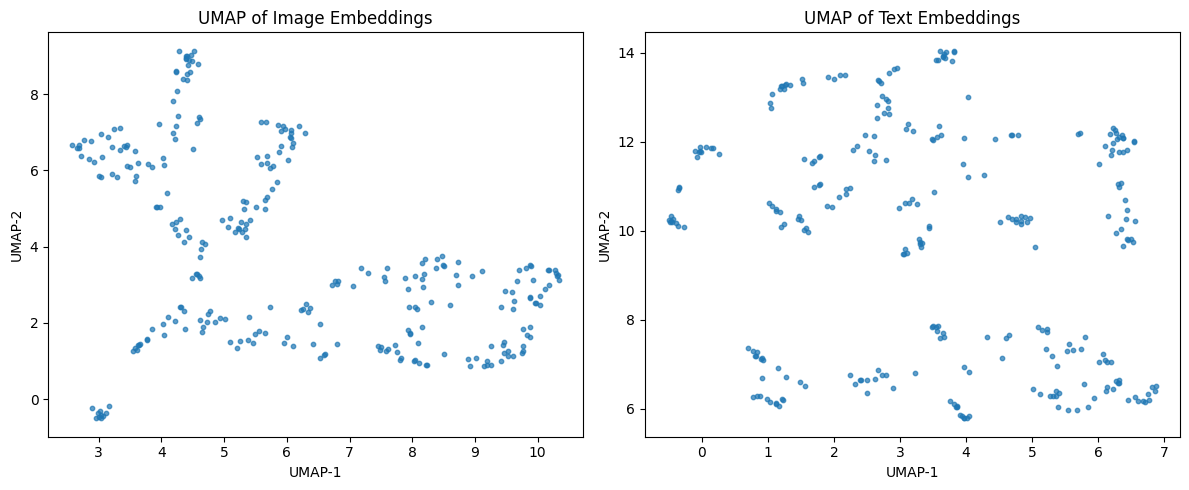

In [65]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Prepare Embeddings
# all_image_embeddings and all_text_embeddings should already be stacked
# If not, stack them first:
# all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
# all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

# Convert to numpy if needed
# Step 1: Prepare Embeddings
# (Assume all_image_embeddings and all_text_embeddings are already stacked and numpy)

image_emb_np = all_image_embeddings
text_emb_np = all_text_embeddings

# Step 2: Run UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
image_proj = umap_model.fit_transform(image_emb_np)
text_proj = umap_model.fit_transform(text_emb_np)

# Step 3: Plot
plt.figure(figsize=(12, 5))

# --- Image Embeddings ---
plt.subplot(1, 2, 1)
plt.scatter(image_proj[:, 0], image_proj[:, 1], s=10, alpha=0.7)
plt.title('UMAP of Image Embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

# --- Text Embeddings ---
plt.subplot(1, 2, 2)
plt.scatter(text_proj[:, 0], text_proj[:, 1], s=10, alpha=0.7)
plt.title('UMAP of Text Embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

plt.tight_layout()
plt.show()


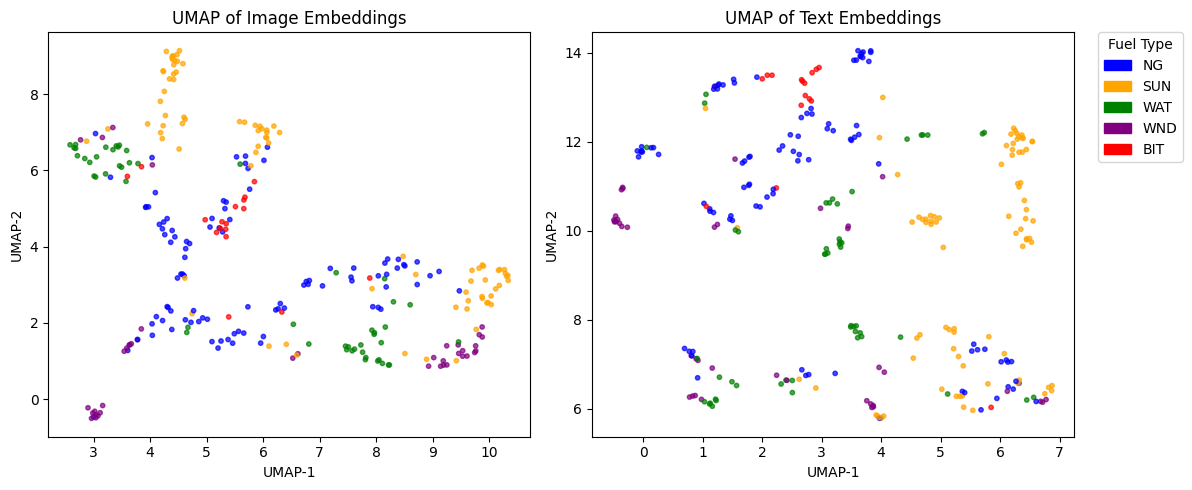

In [72]:
# Example: test_labels = ["NG", "NG", "SUN", "WAT", ...]
# Map fuel types to colors
fuel_type_to_color = {
    "NG": "blue",
    "SUN": "orange",
    "WAT": "green",
    "WND": "purple",
    "BIT": "red"
}

colors = [fuel_type_to_color.get(label, "gray") for label in test_labels]  # Fallback gray if not found

import matplotlib.patches as mpatches

# Create legend handles
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in fuel_type_to_color.items()
]

plt.figure(figsize=(12, 5))

# --- Image Embeddings ---
plt.subplot(1, 2, 1)
plt.scatter(image_proj[:, 0], image_proj[:, 1], s=10, c=colors, alpha=0.7)
plt.title('UMAP of Image Embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

# --- Text Embeddings ---
plt.subplot(1, 2, 2)
plt.scatter(text_proj[:, 0], text_proj[:, 1], s=10, c=colors, alpha=0.7)
plt.title('UMAP of Text Embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

# 🔥 Add the legend NOW, after plots
plt.legend(
    handles=legend_handles,
    title="Fuel Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.show()


# Retrieval Pipeline

In [32]:
pip install faiss-cpu

In [33]:
import torch
from tqdm import tqdm
from collections import Counter

# 📚 Create the dataset and loader
trainval_dataset = PowerPlantContrastiveDataset(
    trainval_image_paths,
    trainval_captions,
    trainval_labels,
    image_transform,
    text_tokenizer
)

trainval_loader = DataLoader(
    trainval_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# 📚 Initialize model (same way you trained!)
image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
text_encoder = RobertaModel.from_pretrained("roberta-base")
model = LitContrastiveModel(image_encoder, text_encoder)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# 📚 Encode all trainval images and captions
all_trainval_image_embeddings = []
all_trainval_text_embeddings = []
trainval_captions_list = []
trainval_labels_list = []  # ✅ To record labels properly

for batch in tqdm(trainval_loader, desc="Encoding Train+Val Images and Captions"):
    with torch.no_grad():
        image = batch['image'].to(model.device)
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)

        image_emb, text_emb = model(image, input_ids, attention_mask)

        all_trainval_image_embeddings.append(image_emb.cpu())
        all_trainval_text_embeddings.append(text_emb.cpu())
        trainval_captions_list.extend(batch['caption'])
        trainval_labels_list.extend(batch['fuel_type'])  # ✅ record labels

# Stack everything
all_trainval_image_embeddings = torch.cat(all_trainval_image_embeddings, dim=0)
all_trainval_text_embeddings = torch.cat(all_trainval_text_embeddings, dim=0)

# 📢 Stronger printing
print(f"\n✅ Finished encoding Train+Val set:")
print(f"   → {all_trainval_image_embeddings.shape[0]} total images encoded")
print(f"   → {all_trainval_text_embeddings.shape[0]} total captions encoded")
print(f"   → {len(trainval_captions_list)} captions collected")
print(f"   → {len(trainval_labels_list)} labels collected")

# 📢 Class distribution (very important to know)
label_distribution = Counter(trainval_labels_list)
print("\nClass distribution among Train+Val embeddings:")
for label, count in label_distribution.items():
    print(f"  {label}: {count} samples")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Encoding Train+Val Images and Captions: 100%|██████████| 51/51 [00:45<00:00,  1.11it/s]


✅ Finished encoding Train+Val set:
   → 1625 total images encoded
   → 1625 total captions encoded
   → 1625 captions collected
   → 1625 labels collected

Class distribution among Train+Val embeddings:
  NG: 543 samples
  WND: 229 samples
  SUN: 469 samples
  WAT: 291 samples
  BIT: 93 samples


In [35]:
import faiss

# 1. Normalize the embeddings
image_emb_np = all_trainval_image_embeddings.numpy()  # It's a torch tensor
faiss.normalize_L2(image_emb_np)

# 2. Build the FAISS index
dimension = image_emb_np.shape[1]  # Should be 768 for ViT
index = faiss.IndexFlatL2(dimension)  # L2 = inner product after normalization (cosine)
index.add(image_emb_np)

print(f"✅ FAISS Index built with {index.ntotal} trainval images.")


✅ FAISS Index built with 1625 trainval images.


In [28]:
pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 12.5 MB/s eta 0:00:00


In [ ]:
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

In [36]:
import torch
import faiss
import numpy as np
from PIL import Image
import torchvision.transforms as T
from collections import Counter
from groq import Groq

# 📚 Step 0: Connect to Groq API
client = Groq(api_key="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")  # Replace with your real key

# 📚 Step 1: Helper to Build the Smart Prompt
def build_prompt(retrieved_captions):
    # Detect the dominant fuel type
    fuel_keywords = ["Wind", "Hydro", "Natural Gas", "Solar", "Biomass"]
    fuel_counts = Counter()

    for caption in retrieved_captions:
        for fuel in fuel_keywords:
            if fuel.lower() in caption.lower():
                fuel_counts[fuel] += 1

    most_common_fuel = fuel_counts.most_common(1)[0][0] if fuel_counts else "unknown fuel type"

    # Build the prompt
    prompt = (
        f"You are an energy analyst. The majority of the retrieved captions describe a plant powered by {most_common_fuel}.\n"
        "Given the following 5 power plant descriptions, extract a likely summary for a new image based on similarity.\n"
        "You MUST include:\n"
        "- The most likely fuel type (e.g., wind, hydro, solar, gas)\n"
        "- A capacity range (MW) that reflects the examples\n"
        "- Estimated energy generation (MWh/year), also as a range if needed\n"
        "- Approximate region or state if visible\n\n"
    )

    for idx, cap in enumerate(retrieved_captions, 1):
        prompt += f"{idx}. {cap}\n"

    prompt += (
        "\nWrite only ONE complete sentence that summarizes the plant type, capacity, generation, and region."
    )

    return prompt

# 📚 Step 2: Helper to Call LLM
def call_llm(prompt, client):
    response = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": "You summarize energy facility metadata from raw descriptions."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=150
    )
    return response.choices[0].message.content

# 📚 Step 3: Full Retrieve + Generate Pipeline
def retrieve_and_generate(test_idx, model, faiss_index, captions_list, image_paths, top_k=5):
    device = model.device

    # Step 1: Load and preprocess the test image
    test_image_path = image_paths[test_idx]
    img = Image.open(test_image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Step 2: Encode the image
    model.eval()
    with torch.no_grad():
        dummy_input_ids = torch.zeros((1, 77), dtype=torch.long).to(device)
        dummy_attention_mask = torch.ones((1, 77), dtype=torch.long).to(device)

        image_emb, _ = model(img_tensor, dummy_input_ids, dummy_attention_mask)
        image_emb = image_emb.cpu().numpy()

    # Step 3: Normalize and Search FAISS
    faiss.normalize_L2(image_emb)
    D, I = faiss_index.search(image_emb, top_k)

    # Step 4: Retrieve Top-K captions
    retrieved_captions = [captions_list[idx] for idx in I[0]]

    # Step 5: Build the prompt
    prompt = build_prompt(retrieved_captions)

    # Step 6: Generate using LLM
    generated_caption = call_llm(prompt, client)

    # Step 7: Print Everything
    print(f"\n🖼️ Test Image Path: {test_image_path}")
    print("\n📚 Retrieved Captions:")
    for i, cap in enumerate(retrieved_captions, 1):
        print(f"{i}. {cap}")

    print("\n📝 Generated Final Caption:")
    print(f"→ {generated_caption}")

    return retrieved_captions, generated_caption


In [37]:
retrieved_caps, final_caption = retrieve_and_generate(
    test_idx= 10,    # Pick any number (0, 1, 2, 5...)
    model=model,
    faiss_index=index,
    captions_list=trainval_captions_list,
    image_paths=test_image_paths,
    top_k=5
)



🖼️ Test Image Path: /content/drive/MyDrive/powerplant_multimodal_project/data/raw/uspp_naip/uspp_naip/naip_1299_CA_NG.tif

📚 Retrieved Captions:
1. The Mojave Siphon power plant, located in San Bernardino County, California, is a hydropower facility with a capacity of 32.7 megawatts. Annually, it generates 10,933 megawatt-hours of electricity.
2. The Questa Solar Facility, located in Taos County, New Mexico, is a solar energy-powered plant with a capacity of 1.0 megawatt. Annually, it generates 2949.0 megawatt-hours of electricity. The plant's fuel mix is comprised entirely of solar energy, with a 100.0 percent solar mix.
3. The Riverside Energy Resource Center, located in Riverside County, California, is a natural gas-fired power plant with a capacity of 196.0 megawatts. In a year, the plant generates 49,084.0 megawatt-hours of electricity and emits 30,339.0 tons of carbon dioxide.
4. The Pitchess Cogen Station, located in Los Angeles County, California, is a natural gas-fired power 


🖼️ Test Image Path: /content/drive/MyDrive/powerplant_multimodal_project/data/raw/uspp_naip/uspp_naip/naip_5725_NJ_SUN.tif

📚 Retrieved Captions:
1. The Sanford power plant, located in Volusia County, Florida, has a capacity of 2534.0 megawatts and generates 9206252.0 megawatt-hours of electricity per year, primarily fueled by natural gas. Annually, the plant emits 4149222.0 tons of carbon dioxide.
2. The Hall's Warehouse Solar Project, located in Middlesex County, New Jersey, is a solar energy-powered electricity generation facility with an installed capacity of 1.7 megawatts. In a typical year, the plant produces 1280.0 megawatt-hours of electricity. The facility's fuel mix is comprised entirely of solar energy, with a 100.0 percent solar mix, and does not involve the use of wind or biomass energy sources.
3. The Harmon DC Totowa NJ power plant, located in Passaic County, New Jersey, is a solar energy-based facility with an installed capacity of 1.5 megawatts. In a typical year, the

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


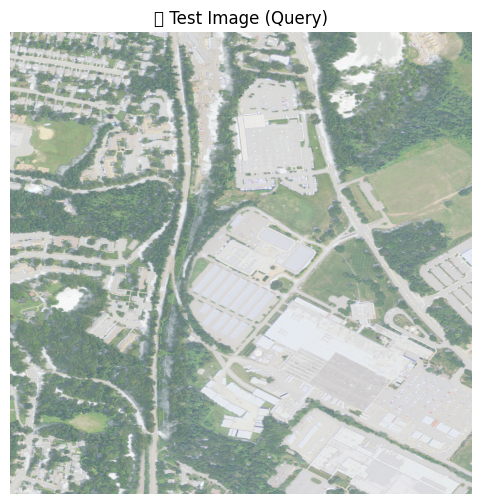

🎯 Ground-Truth Caption:
→ The Tioga Solar Morris County 1 LLC power plant, located in Morris County, New Jersey, is a solar energy-powered facility with an installed capacity of 1.0 megawatt. Annually, the plant generates 1511.0 megawatt-hours of electricity, with a solar energy mix of 100.0 percent.


In [42]:
import matplotlib.pyplot as plt
from IPython.display import display

# Step 1: Run the pipeline
test_idx = 100 # Change as needed
retrieved_caps, final_caption = retrieve_and_generate(
    test_idx=test_idx,
    model=model,
    faiss_index=index,
    captions_list=trainval_captions_list,
    image_paths=test_image_paths,
    top_k=5
)

# Step 2: Display original image/
img_path = test_image_paths[test_idx]
original_caption = test_captions[test_idx]  # Only works if you have this ground-truth test_captions list!

img = Image.open(img_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("🖼️ Test Image (Query)")
plt.show()

# Step 3: Show original caption
print("🎯 Ground-Truth Caption:")
print(f"→ {original_caption}")



In [39]:
# Assume you already have:
test_idx = 10
model = model  # Your trained model
test_image_path = test_image_paths[test_idx]

# Step 1: Load and preprocess query image
query_image = Image.open(test_image_path).convert("RGB")
query_image = image_transform(query_image)  # Apply the same transforms!
query_image = query_image.unsqueeze(0)  # Add batch dimension

# Step 2: Encode it
query_image = query_image.to(model.device)

with torch.no_grad():
    query_image_embedding, _ = model.image_encoder(query_image).last_hidden_state[:, 0], None  # (1, 768)

# Now you have query_image_embedding ready!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


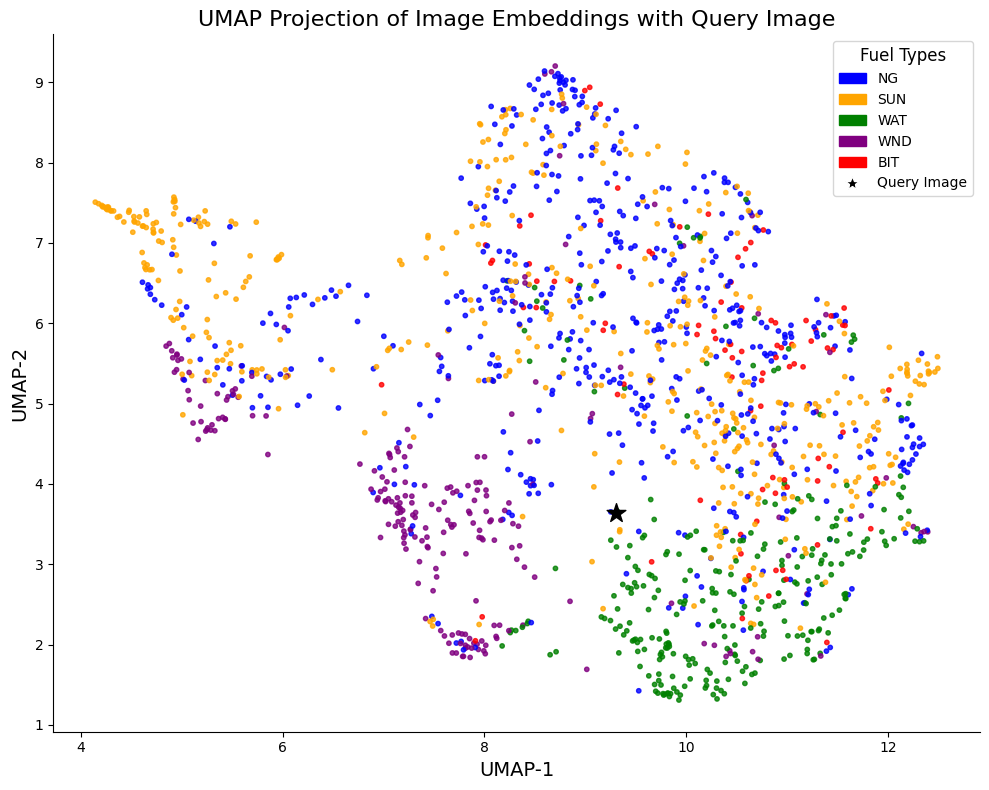

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import umap
import numpy as np
import torch
import faiss

# ---- Stack Embeddings ----
all_embs = torch.cat([
    all_trainval_image_embeddings.to(model.device),
    query_image_embedding.to(model.device)
], dim=0)


# Normalize embeddings
all_embs_np = all_embs.cpu().numpy()
faiss.normalize_L2(all_embs_np)

# UMAP Projection
umap_model = umap.UMAP(n_components=2, random_state=42)
all_proj = umap_model.fit_transform(all_embs_np)

trainval_proj = all_proj[:-1]
query_proj = all_proj[-1]

# Color Mapping
fuel_type_to_color = {
    "NG": "blue",
    "SUN": "orange",
    "WAT": "green",
    "WND": "purple",
    "BIT": "red"
}
trainval_colors = [fuel_type_to_color.get(label, "gray") for label in trainval_labels]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 8))

# Plot training/validation samples
scatter = ax.scatter(
    trainval_proj[:, 0], trainval_proj[:, 1],
    c=trainval_colors, s=10, alpha=0.8
)

# Plot query image
ax.scatter(
    query_proj[0], query_proj[1],
    marker="*", c="black", s=200, label="Query Image"
)

# Legend
handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in fuel_type_to_color.items()
]
handles.append(plt.Line2D([0], [0], marker='*', color='w', label='Query Image', markerfacecolor='black', markersize=10))
ax.legend(handles=handles, title="Fuel Types", fontsize=10, title_fontsize=12, loc='upper right')

# Aesthetic Cleanups
ax.set_title("UMAP Projection of Image Embeddings with Query Image", fontsize=16)
ax.set_xlabel("UMAP-1", fontsize=14)
ax.set_ylabel("UMAP-2", fontsize=14)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.show()
